In [26]:
from sklearn import model_selection
import numpy as np
import pandas as pd
from tabulate   import tabulate
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.naive_bayes     import GaussianNB
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve, f1_score, accuracy_score, precision_score, recall_score

# Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. <br>
SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 

#### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.

In [4]:
data = pd.read_csv("galaxyquasar.csv")

In [5]:
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

In [6]:
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])

In [7]:
label   = np.array(data['class']=='QSO', dtype='int')

- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

In [8]:
color = np.array([u_g,g_r,r_i,i_z]).T
print(color.shape)

(50000, 4)


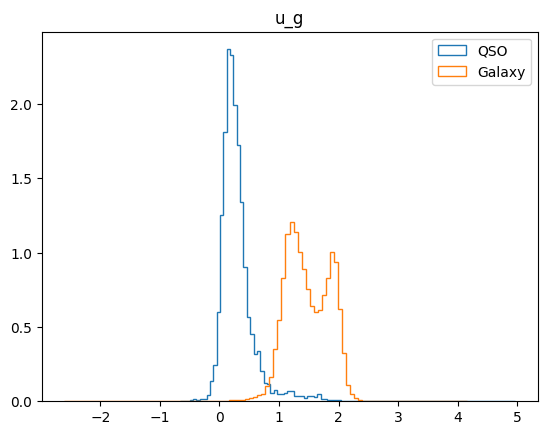

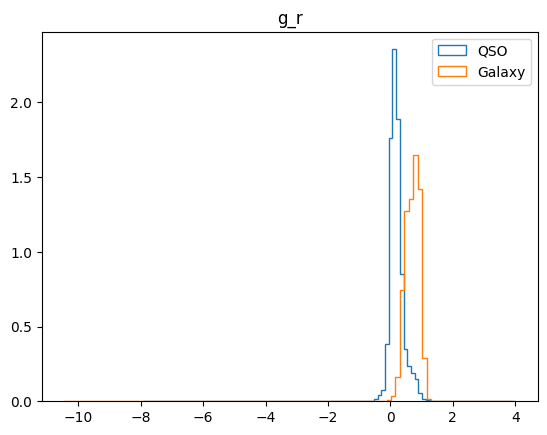

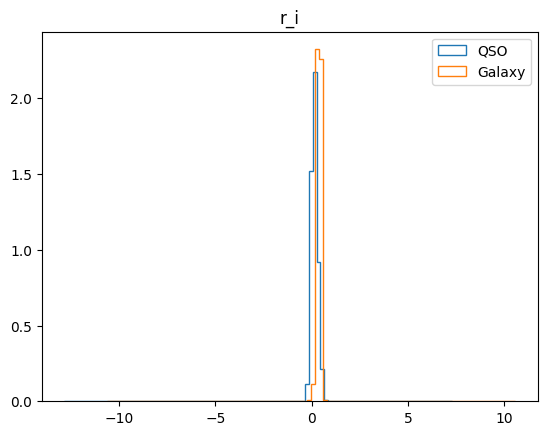

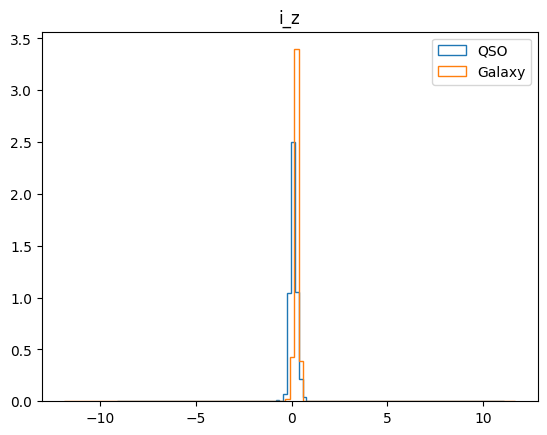

In [9]:
for i,colors in zip(range(color.shape[1]),['u_g','g_r','r_i','i_z']):
    plt.hist(color[:,i][label==1],bins=100, histtype='step', density=True, label='QSO')
    plt.hist(color[:,i][label==0],bins=100, histtype='step', density=True, label='Galaxy')
    plt.legend()
    plt.title(colors)
    plt.show()

The bimodality is more evident for the u_g color.

Splitting the dataset, looking at different colours:

In [10]:
# First, I'll try with Linear Discriminant Analysis, Quadratic Discriminant Analysis, and Gauss Naive Bayes classifier
models = [LDA(), QDA(), GaussianNB()]

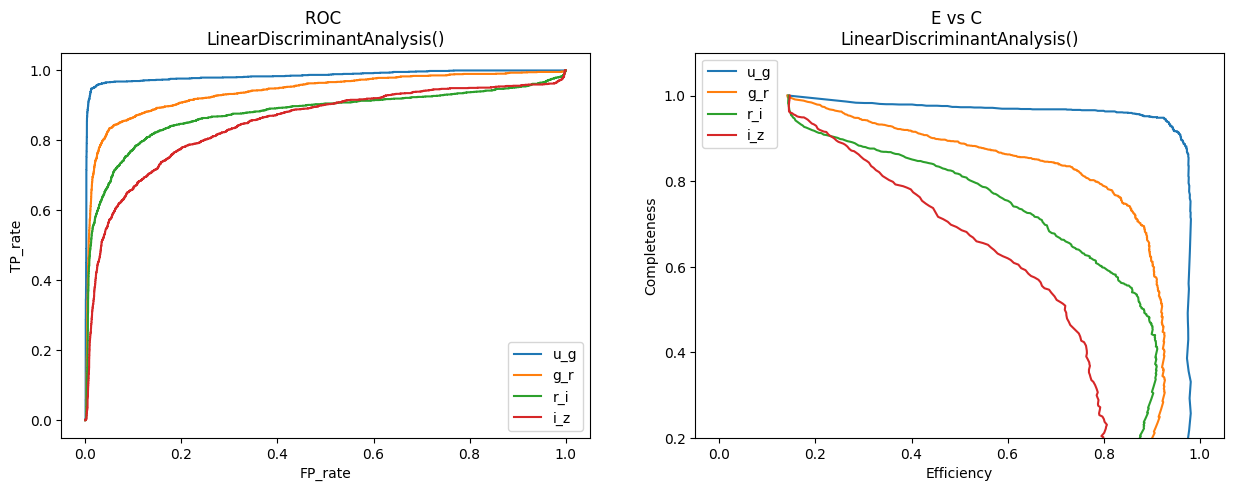

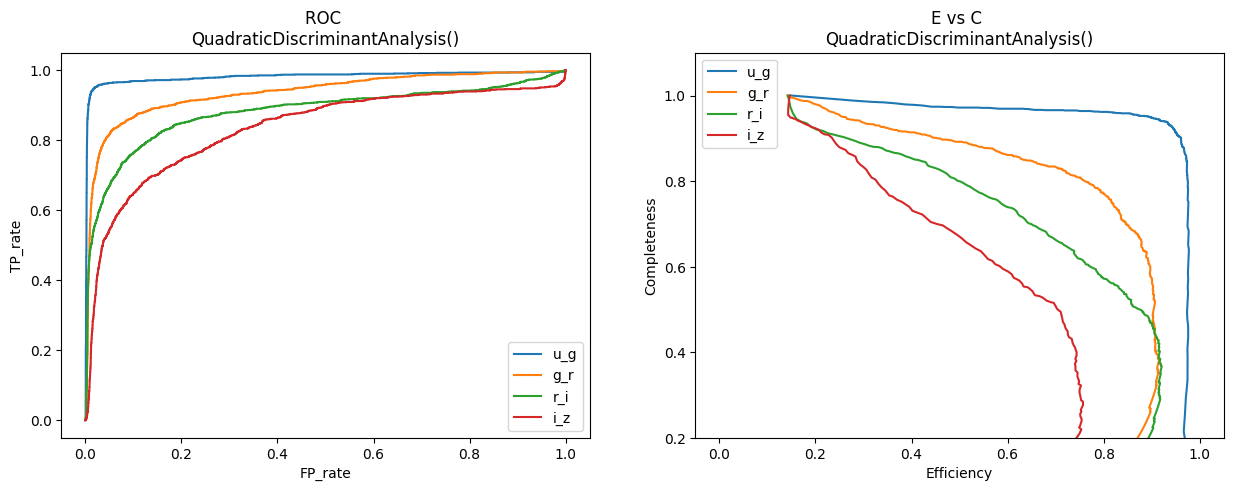

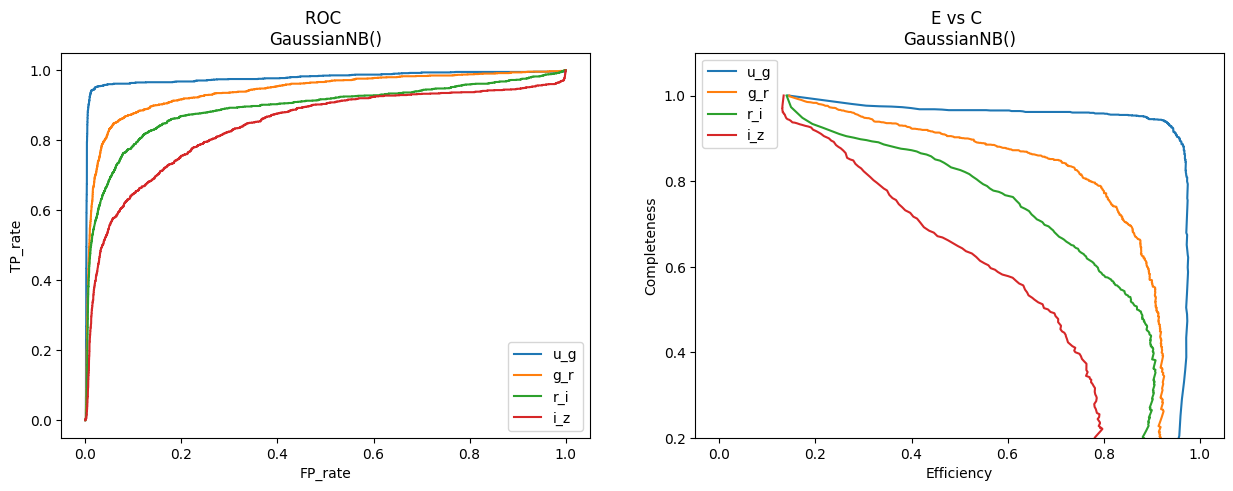

In [11]:
for model in models:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for c, name in zip(color.T,['u_g','g_r','r_i','i_z']):
        xtrain, xtest, ytrain, ytest = train_test_split(c[:,None], label, test_size=0.2)
        model.fit(xtrain, ytrain)
        ypred = model.predict(xtest)
        # predict_proba gives the results of classification in form of probabilities
        y_probabilities = model.predict_proba(xtest)[:,1]
        FP_rate, TP_rate, threshold = roc_curve(ytest, y_probabilities)
        
        # plot
        ax[0].plot(FP_rate, TP_rate, label = name)
        ax[0].set_xlabel('FP_rate')
        ax[0].set_ylabel('TP_rate')
        ax[0].set_title('ROC \n' + str(model))
        ax[0].legend()

        completeness, contamination = completeness_contamination(ypred, ytest)
        efficiency = 1 - completeness
        #print('Total completeness for', name,' with ', str(model), ' is ', completeness)
        #print('Total efficiency for', name,' with ', str(model), ' is ', efficiency)
        thresholds = np.linspace(0, 1, 1001)
        completeness_cumulative = np.zeros_like(thresholds)
        contamination_cumulative   = np.zeros_like(thresholds)
        for i, t in enumerate(thresholds):
            ypred_temp = (y_probabilities >= t)
            completeness_cumulative[i], contamination_cumulative[i] = completeness_contamination(ypred_temp, ytest)
        
        ax[1].plot(1-contamination_cumulative, completeness_cumulative, label = name)
        ax[1].set_ylim(0.2,1.1)
        ax[1].set_xlabel('Efficiency')
        ax[1].set_ylabel('Completeness')
        ax[1].set_title('E vs C \n' + str(model))
        ax[1].legend()
    plt.show()

Looking at these ROC curves, I can say that the u_g color is the most important feature. <br>
Now, I want to try out the Gaussian Mixture Models classifier and the K-Neighbor classifier. <br>
To do so, I will focus only on the u_g color.

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(color.T[0][:,None], label, test_size=0.2)

In [13]:
# number of galaxies
np.sum(label == 0)

42866

In [14]:
# number of quasars
np.sum(label == 1)

7134

In [15]:
42866/7134

6.008690776562938

GMM and K-Neighbor depends on the number of components and number of neighbors, to find the best numbers I will use cross-validation. <br>
To decide the best number, I decide to maximize the $F1-score$, which is a better metric than only accuracy, because it maximises both precision and recall. It is useful for imbalanced classes. <br>
Since here we have almost 1 galaxy every 6 quasars!
$$
F1\_score = 2 * \frac{completeness\cdot purity}{completeness + purity}
$$
with $completeness = \frac{TP}{TP+FN}$ and $purity = \frac{TP}{TP+FP}$.

NB I also tried to to it with accuracy, with u_g color they are well separated so the accuracy is still a valid metric to use!
$$
accuracy = \frac{\#\; of\; correct\; predictions}{tot\; \#\; of\; predictions}
$$

**GMM classifier**

In [16]:
#with KFold, each fold is used once as a validation
kf = KFold(n_splits=5, shuffle=True)
n_components = np.linspace(1, 20, 20, dtype=int)
#scores_cv_acc = []
scores_cv_f1  = []
for n in n_components:
    # the number of components refers to the number of Gaussians used to model the data in each class
    # in astroML, n_component is the same for each class
    gmm_classifier = GMMBayes(n_components = n)
    cv_predictions = cross_val_predict(gmm_classifier, color.T[0][:,None], label, cv=kf)
    #scores_cv_acc.append(accuracy_score(label, cv_predictions))
    scores_cv_f1.append(f1_score(label, cv_predictions))
    
best_n_f1 = n_components[np.argmax(scores_cv_f1)]
#best_n_acc = n_components[np.argmax(scores_cv_acc)]
print('The best number of components according to F1-score is ',best_n_f1)
#print('The best number of components according to accuracy is ',best_n_acc)

The best number of components according to F1-score is  17


In [17]:
#plt.scatter(n_components, scores_cv_f1)
#plt.scatter(n_components, scores_cv_acc)
#plt.plot(n_components, scores_cv_f1, '--', label='F1')
#plt.plot(n_components, scores_cv_acc, '--', label='accuracy')
#plt.legend()
#plt.xlabel('# of components')
#plt.show()

**K-Neighbor classifier**

In [18]:
kf = KFold(n_splits=5, shuffle=True)
k_n = np.linspace(1, 20, 20, dtype=int)
model_k = KNeighborsClassifier()
# I'm using Grid Search, for each combination of hyperparameters (here only the # of neighbors) does a cross-validation
grid = GridSearchCV(model_k, param_grid={'n_neighbors': k_n}, cv=kf, scoring='f1')
grid.fit(color.T[0][:,None], label)
best_k = grid.best_params_['n_neighbors']

In [19]:
best_k

17

Now, use all the classifiers on the u_g color alone, and see the reseults.

In [20]:
models = [LDA(), QDA(), GaussianNB(), GMMBayes(n_components = best_n_f1), KNeighborsClassifier(n_neighbors=best_k)]

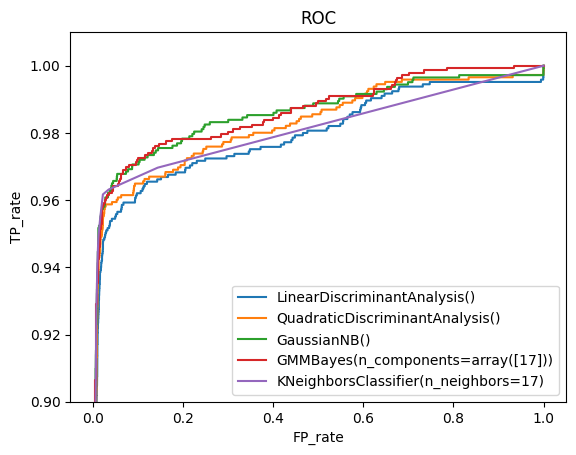

In [24]:
accuracy  = []
precision = []
recall    = []
for model in models:
    xtrain, xtest, ytrain, ytest = train_test_split(color.T[0][:,None], label, test_size=0.2)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    y_probabilities = model.predict_proba(xtest)[:,1]
    accuracy.append(accuracy_score(ytest, ypred))
    precision.append(precision_score(ytest, ypred))
    recall.append(recall_score(ytest, ypred))
    FP_rate, TP_rate, threshold = roc_curve(ytest, y_probabilities)
    # plot
    plt.plot(FP_rate, TP_rate, label = model)
plt.xlabel('FP_rate')
plt.ylabel('TP_rate')
plt.ylim(0.9,1.01)
plt.title('ROC')
plt.legend()
plt.show()

In [28]:
metrics_  = np.array([accuracy, precision, recall]).T
col_names = ['accuracy', 'precision', 'completeness']
tabella_  = [[col] + list(row) for col, row in zip(models, metrics_)]
headers   = [''] + col_names
tabulate(tabella_, headers=headers, tablefmt='html')

,accuracy,precision,completeness
LinearDiscriminantAnalysis(),0.9788,0.930411,0.922705
QuadraticDiscriminantAnalysis(),0.9804,0.939246,0.925034
GaussianNB(),0.9823,0.93899,0.937019
GMMBayes(n_components=array([17])),0.9821,0.94306,0.930478
KNeighborsClassifier(n_neighbors=17),0.9828,0.942336,0.932803
